# Example 3. Generate PLA hypotheses by shuffleing data
------
### Import basic needed modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from Perceptron_online import Perceptron_online
from plot_decision_regions import * 
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True

---
### Greate generating-hypotheses class 

In [2]:
class GenHypothesis_PLA(object):
    
        def __init__(self, dataframe, idx_X, idx_y):
            self.df = dataframe
            self.iX = idx_X
            self.iy = idx_y
        
        # Generate hypotheses
        def genHyps(self, n_hyps=1, eta=0.1, max_iter=1):
            # Initialize variables
            self.pla = []
            self.c0 = [] # c0 = -*w0/w2
            self.c1 = [] # c1 = -*w1/w2
            self.n_hyps = int(abs(n_hyps))
            print 'Generating %d PLA hyp. ....'%(self.n_hyps)
            
            for i in range(self.n_hyps):
                # print i
                # Copy & Shuffle dataframe
                np.random.seed(i)
                df = self.df.reindex(np.random.permutation(self.df.index))
                y = df.iloc[:, self.iy].values
                X = df.iloc[:, self.iX].values
                idx = df.index.values
 
                # Run PLA
                pla = Perceptron_online(eta=eta)
                pla.fit(X, y, max_iter=max_iter)
                self.c0.append(-1*pla.w_[0]/pla.w_[2])
                self.c1.append(-1*pla.w_[1]/pla.w_[2])
                self.pla.append(pla)
                
                if i is 0 :
                    self.X = X
                    self.y = y
            print 'Done'
            return

        # Aggregation of hypotheses
        def predict(self, X=None, outputBound=False):
            if X is None: X = self.X 

            # Linear sum as voting
            predict = self.pla[0].predict(X)
            for i in range(1, self.n_hyps):
                predict += self.pla[i].predict(X)    

            if outputBound and predict == 0.:
                return 0.
            else:    
                return np.where(predict >= 0.0, 1, -1)

        # Get boundary points
        def getBoundary(self, xmin, xmax, ymin, ymax, deg_pfit=1, resolution=0.01):
            print 'Scaning the boundary....'
            self.boundary_points = np.array([])
            # Make a grid map
            xy, yx = np.meshgrid( np.arange(xmin, xmax, resolution),
                                  np.arange(ymin, ymax, resolution))

            for X in np.array([xy.ravel(), yx.ravel()]).T:
                if self.predict( X=X, outputBound=True ) == 0.: 
                    if len(self.boundary_points) == 0:
                        self.boundary_points = X
                    else :
                        self.boundary_points = np.vstack((self.boundary_points, X))
                    #self.boundary_points.append(X.tolist())

            # fit the points
            self.boundary_pars = np.polyfit(self.boundary_points[:,0], self.boundary_points[:,1], deg_pfit)
            self.boundary_func = np.poly1d(self.boundary_pars)
            print '%d-D Fit pars (p[%d]*x^[%d]+....+p[0]) : %s'%( deg_pfit, deg_pfit, deg_pfit, str(self.boundary_pars))                                
            
            return self.boundary_pars
            
            

### Input data and generate PLA hypotheses

In [3]:
df = pd.read_csv('iris.data', header=None)[:100] # Keep data from 0-99
df.columns = ['sepal_length', 'x_1', 'petal_length', 'x_3', 'type']
df.iloc[48:52]

,sepal_length,x_1,petal_length,x_3,type
48,5.3,3.7,1.5,0.2,Iris-setosa
49,5.0,3.3,1.4,0.2,Iris-setosa
50,7.0,3.2,4.7,1.4,Iris-versicolor
51,6.4,3.2,4.5,1.5,Iris-versicolor


In [4]:
df.loc[df['type'] == 'Iris-setosa', 'type'] = -1
df.loc[df['type'] == 'Iris-versicolor', 'type'] = 1
df.iloc[48:52]

,sepal_length,x_1,petal_length,x_3,type
48,5.3,3.7,1.5,0.2,-1
49,5.0,3.3,1.4,0.2,-1
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1


### Generate many hypotheses
1\. Generate the hypotheses and show in the plot

In [5]:
n_hyps=200
max_iter=10
hyps_PLA = GenHypothesis_PLA(dataframe=df, idx_X=[0,2], idx_y=4)
hyps_PLA.genHyps(n_hyps=n_hyps, eta=0.1, max_iter=max_iter)

Generating 200 PLA hyp. ....
Done


In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(hyps_PLA.X[ hyps_PLA.y == 1, 0], hyps_PLA.X[ hyps_PLA.y == 1, 1], color='blue', marker='x', label='versicolor')
plt.scatter(hyps_PLA.X[ hyps_PLA.y ==-1, 0], hyps_PLA.X[ hyps_PLA.y ==-1, 1], color='red',  marker='o', label='setosa')
plt.xlabel('petal length', fontsize=18)
plt.ylabel('sepal length', fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.xlim(0., 8.)
plt.ylim(0., 6.)
#plt.show()

(0.0, 6.0)

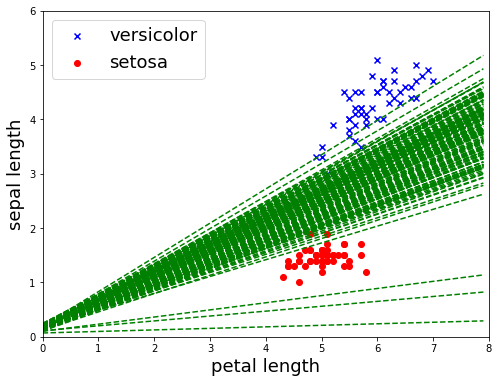

In [7]:
x = np.arange(0., 8., 0.1)

for i in range(n_hyps):
    plt.plot(x, hyps_PLA.c0[i]+hyps_PLA.c1[i]*x, 'g--')

plt.show()

2\. Aggregate all hypotheses and find the new boundary

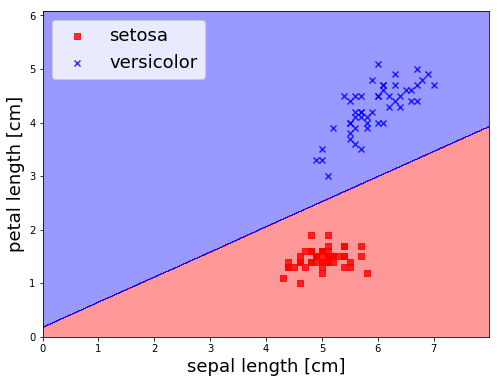

In [8]:
plt.figure(figsize=(8, 6))
plot_decision_regions(hyps_PLA.X, hyps_PLA.y, classifier=hyps_PLA, resolution=0.01)
plt.xlabel('sepal length [cm]', fontsize=18)
plt.ylabel('petal length [cm]', fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.show()
#print hyps_PLA.pla[i].w_

Scaning the boundary....
1-D Fit pars (p[1]*x^[1]+....+p[0]) : [ 0.47172169  0.1707477 ]


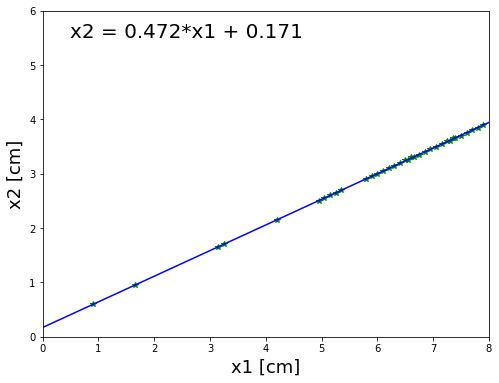

In [9]:
# Use grid to find out the boundary points, i.e the prediction is 0, neither >0 or <0
plt.figure(figsize=(8, 6))
hyps_PLA.getBoundary(xmin=0, xmax=8, ymin=0, ymax=5, resolution=0.05)
xf = np.linspace(0,8,100)
yf = hyps_PLA.boundary_func(xf)
plt.plot(hyps_PLA.boundary_points[:,0], hyps_PLA.boundary_points[:,1], 'g*', xf, yf, 'b-')
plt.text(0.5, 5.5, 'x2 = %.3f*x1 + %.3f'%(hyps_PLA.boundary_pars[0], hyps_PLA.boundary_pars[1]), fontsize=20)
plt.xlim(0,8)
plt.ylim(0,6)
plt.xlabel('x1 [cm]', fontsize=18)
plt.ylabel('x2 [cm]', fontsize=18)
plt.show()
#print hyps_PLA.boundary_points.tolist()

3\. See the detail of the hypotheses 

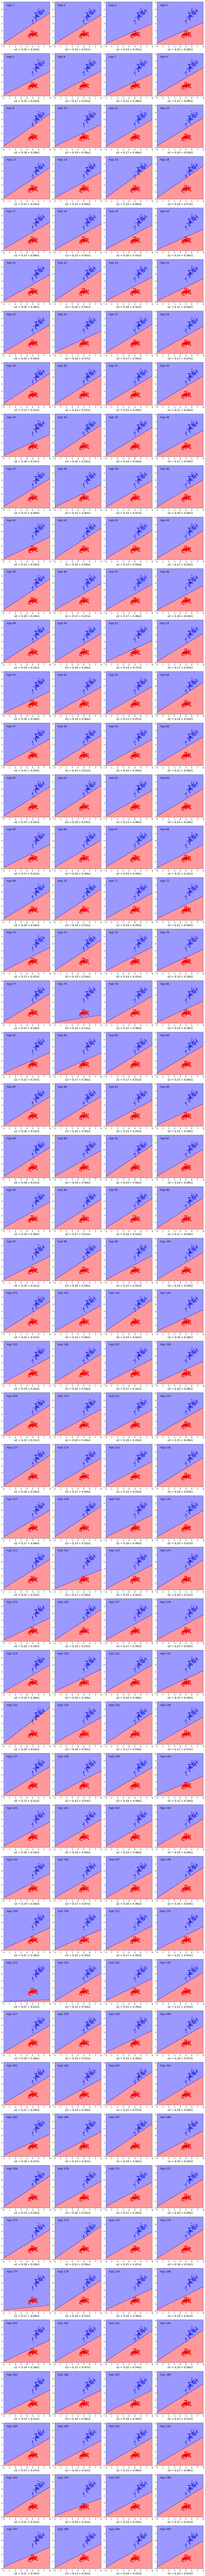

In [10]:
cplot=4
fig = plt.figure(figsize=(16, n_hyps))
for i in range(n_hyps):
    fig.add_subplot(n_hyps/cplot, cplot, i+1)
    plot_decision_regions(hyps_PLA.X, hyps_PLA.y, classifier=hyps_PLA.pla[i], resolution=0.01)
    plt.xlabel('x2 = %.2f + %.2fx1'%(hyps_PLA.c0[i], hyps_PLA.c1[i]), fontsize='x-large' )
    plt.text(0.5, 5.5, 'Hyp '+str(i+1), fontsize='x-large')
plt.tight_layout()
plt.show()

### Conclusion
By generating different PLA hypotheses, we can find the variations in PLA by shuffleing the data order. Not supprised for the resurlts, most of the hyperplanes lay on the gap between *iris-setosa* and *iris-versicolor*, but few of them are out of the region. After the simple uniform aggregation, the aggregated hyperplane locates right between two categories, i.e. the distance from hyperplane to the closest data points of *iris-setosa* and *iris-versicolor* are similar. Somehow, the simple PLA can be improve by aggregation.